In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as sf
import statsmodels.api as smf
import pandas as pd
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import summary_table
import scipy.stats as stats

In [2]:
covid_data_df = pd.read_csv('../../../../data/stage_3/covid_confirmed_usafacts.csv')
population_df = pd.read_csv('../../../../data/stage_3/covid_county_population_usafacts.csv')
death_df = pd.read_csv('../../../../data/stage_3/covid_deaths_usafacts.csv')

In [3]:
covid_data_df = covid_data_df[covid_data_df["County Name"] != 'Statewide Unallocated']
population_df = population_df[population_df["County Name"] != 'Statewide Unallocated']
death_df = death_df[death_df["County Name"] != 'Statewide Unallocated']

In [4]:
covid_data_df_nc = covid_data_df[covid_data_df['State']=='NC']
covid_data_death_df_nc = death_df[death_df['State']=='NC']
population_df_nc = population_df[population_df['State']=='NC']

#### Creating a long format for new cases in NORTH CAROLINA

In [5]:
covid_data_df_nc_idx = covid_data_df_nc.set_index(['countyFIPS','County Name','State','StateFIPS'])
covid_data_df_nc_idx_diff = covid_data_df_nc_idx.diff(axis=1)
covid_data_df_nc_idx_diff = covid_data_df_nc_idx_diff.drop(columns=['2020-01-22'])
covid_data_df_nc_idx_diff = covid_data_df_nc_idx_diff.reset_index()
covid_data_melt = covid_data_df_nc_idx_diff.melt(id_vars=['County Name','countyFIPS','State','StateFIPS'],var_name="Date", value_name="new_cases")
covid_data_melt = covid_data_melt.rename(columns={"County Name":"CountyName"})
covid_data_melt

,CountyName,countyFIPS,State,StateFIPS,Date,new_cases
0,Alamance County,37001,NC,37,2020-01-23,0.0
1,Alexander County,37003,NC,37,2020-01-23,0.0
2,Alleghany County,37005,NC,37,2020-01-23,0.0
3,Anson County,37007,NC,37,2020-01-23,0.0
4,Ashe County,37009,NC,37,2020-01-23,0.0
...,...,...,...,...,...,...
57195,Wayne County,37191,NC,37,2021-08-16,119.0
57196,Wilkes County,37193,NC,37,2021-08-16,111.0
57197,Wilson County,37195,NC,37,2021-08-16,75.0
57198,Yadkin County,37197,NC,37,2021-08-16,59.0


#### Creating a long format for new death cases in NORTH CAROLINA

In [6]:
covid_data_df_death_nc_idx = covid_data_death_df_nc.set_index(['countyFIPS','County Name','State','StateFIPS'])
covid_data_death_df_nc_idx_diff = covid_data_df_death_nc_idx.diff(axis=1)
covid_data_death_df_nc_idx_diff = covid_data_death_df_nc_idx_diff.drop(columns=['2020-01-22'])
covid_data_death_df_nc_idx_diff = covid_data_death_df_nc_idx_diff.reset_index()
covid_data_death_melt = covid_data_death_df_nc_idx_diff.melt(id_vars=['County Name','countyFIPS','State','StateFIPS'],var_name="Date", value_name="new_death_cases")
covid_data_death_melt = covid_data_death_melt.rename(columns={"County Name":"CountyName"})

In [7]:
covid_data_death_melt

,CountyName,countyFIPS,State,StateFIPS,Date,new_death_cases
0,Alamance County,37001,NC,37,2020-01-23,0.0
1,Alexander County,37003,NC,37,2020-01-23,0.0
2,Alleghany County,37005,NC,37,2020-01-23,0.0
3,Anson County,37007,NC,37,2020-01-23,0.0
4,Ashe County,37009,NC,37,2020-01-23,0.0
...,...,...,...,...,...,...
57195,Wayne County,37191,NC,37,2021-08-16,0.0
57196,Wilkes County,37193,NC,37,2021-08-16,0.0
57197,Wilson County,37195,NC,37,2021-08-16,0.0
57198,Yadkin County,37197,NC,37,2021-08-16,0.0


#### Find the sum of cases per day county level normalized for 1000000 population
#### Robeson County 
#### Sampson County
#### Hyde County
#### Stanly County
#### Columbus County

In [8]:
merges = pd.merge(covid_data_melt,population_df_nc)
covid_data_melt_group = merges.groupby(['County Name','population','countyFIPS'])['new_cases'].sum().reset_index()

In [9]:
covid_data_melt_group['new_cases'] = round(covid_data_melt_group['new_cases']/covid_data_melt_group['population'] * 1000000)

In [10]:
county_wise_sorted = covid_data_melt_group.sort_values(by = ["new_cases"], ascending=False)
county_wise_sorted.head()

,County Name,population,countyFIPS,new_cases
77,Robeson County,130625,37155,149604.0
81,Sampson County,63531,37163,141285.0
47,Hyde County,4937,37095,139761.0
83,Stanly County,62806,37167,138777.0
23,Columbus County,55508,37047,138665.0


#### Top Five affected Counties normalized by 1000000 population are
#### Montgomery County 
#### Rutherford County
#### Northampton County
#### Jones County
#### Columbus County

In [11]:
merged_death_pop = pd.merge(covid_data_death_melt,population_df_nc)
death_group = merged_death_pop.groupby(['County Name','population','countyFIPS'])['new_death_cases'].sum().reset_index()
death_group['new_death_cases'] = round(death_group['new_death_cases']/death_group['population'] * 1000000)

In [12]:
county_wise_sorted_death = death_group.sort_values(by = ["new_death_cases"], ascending=False)
county_wise_sorted_death.head()

,County Name,population,countyFIPS,new_death_cases
61,Montgomery County,27173,37123,3570.0
80,Rutherford County,67029,37161,3357.0
65,Northampton County,19483,37131,3131.0
51,Jones County,9419,37103,3079.0
23,Columbus County,55508,37047,2918.0


#### Generate a Linear model for NC state new cases

In [13]:
new_cases_summed_bydate = covid_data_melt.groupby(['Date'])['new_cases'].sum().reset_index()
death_cases_summed_bydate = covid_data_death_melt.groupby(['Date'])['new_death_cases'].sum().reset_index()
nc_super_df = pd.merge(new_cases_summed_bydate,death_cases_summed_bydate)

In [14]:
new_case_firstday = nc_super_df['new_cases'].astype(int).tolist()
new_death_case_firstday = nc_super_df['new_death_cases'].astype(int).tolist()

#### Get the index of First day of new case and consider the dataframe from that index only

In [15]:
newcase = next((i for i, j in enumerate(new_case_firstday) if j >0 ), None)
nc_super_df_firstcase = nc_super_df.loc[newcase:,['Date','new_cases']]
# Add a new column num_of_days in an order of index, but starting from 1 to assign x-value i.e 
# number of days from the first day of infection
mylist = []
for i in range(1,(len(nc_super_df_firstcase)+1)):
    mylist.append(i)
nc_super_df_firstcase['num_of_days'] = mylist
nc_super_df_firstcase.head()

,Date,new_cases,num_of_days
40,2020-03-03,1.0,1
41,2020-03-04,0.0,2
42,2020-03-05,0.0,3
43,2020-03-06,1.0,4
44,2020-03-07,0.0,5


#### Get the index of First day of new death case and consider the dataframe from that index only

In [16]:
new_death_case = next((i for i, j in enumerate(new_death_case_firstday) if j >0 ), None)
nc_super_df_first_deathcase = nc_super_df.loc[new_death_case:,['Date','new_death_cases']]

In [17]:
mylist2 = []
for i in range(1,(len(nc_super_df_first_deathcase)+1)):
    mylist2.append(i)
nc_super_df_first_deathcase['num_of_days'] = mylist2
nc_super_df_first_deathcase.head()

,Date,new_death_cases,num_of_days
62,2020-03-25,1.0,1
63,2020-03-26,0.0,2
64,2020-03-27,2.0,3
65,2020-03-28,1.0,4
66,2020-03-29,0.0,5


In [18]:
#nc_super_df.to_csv('../../../../data/stage_3/nc_super_data.csv',index=False)
load_nc = pd.read_csv('../../../../data/stage_3/nc_super_data.csv')

#### Linear Regression Model for number of new cases in NORTH CAROLINA

In [19]:
def generate_model(degree,load_nc,casetype):
    x = load_nc['num_of_days']
    y=""
    y_pred = ""
    model = ""
    x_pred = pd.DataFrame({'num_of_days': np.linspace(load_nc.num_of_days.min(), load_nc.num_of_days.max(), len(load_nc))})
    # Fetching number of cases as per death and new cases dataset
    if(casetype=="new"):
        y = abs(load_nc['new_cases'])
    if(casetype=="death"):
        y = abs(load_nc['new_death_cases'])
    # Calculating first degree Linear model    
    if(degree==1 and casetype == 'new'):
        model = sf.ols(formula='new_cases ~ num_of_days', data=load_nc).fit()
        y_pred = model.predict(x_pred)
    elif(degree==1 and casetype == 'death'):
        model = sf.ols(formula='new_death_cases ~ num_of_days', data=load_nc).fit()
        y_pred = model.predict(x_pred)    
    # Polynomial regression models - fitting the model to respective degress
    elif(degree>1):
            poly_features = PolynomialFeatures(degree=degree)
            x= smf.add_constant(x_pred)
            x_values = poly_features.fit_transform(x)
            model = smf.OLS(y,x_values).fit()
            y_pred = model.predict(x_values)
    calculate_model_params(model,y,y_pred)        
    return model, y_pred             

In [20]:
def calculate_model_params(model,y_act,y_pred):
    print("RMSE(Root Mean Square Error) value for the Linear model is: ",rmse(y_act,y_pred))

In [21]:
nc_super_df_firstcase.dtypes

Date            object
new_cases      float64
num_of_days      int64
dtype: object

#### calculating RMSE values degree from 1 upto 5

In [22]:
model1, y_pred1 = generate_model(1,nc_super_df_firstcase,'new')
model2, y_pred2 = generate_model(2,nc_super_df_firstcase,"new")
model3, y_pred3 = generate_model(3,nc_super_df_firstcase,"new")
model4, y_pred4 = generate_model(4,nc_super_df_firstcase,"new")
model5, y_pred5 = generate_model(5,nc_super_df_firstcase,"new")
model6, y_pred6 = generate_model(6,nc_super_df_firstcase,"new")

RMSE(Root Mean Square Error) value for the Linear model is:  2686.3631978651074
RMSE(Root Mean Square Error) value for the Linear model is:  2491.785414190456
RMSE(Root Mean Square Error) value for the Linear model is:  2491.4433405199457
RMSE(Root Mean Square Error) value for the Linear model is:  2325.189981980821
RMSE(Root Mean Square Error) value for the Linear model is:  2167.043897035659
RMSE(Root Mean Square Error) value for the Linear model is:  2171.3521857369133


In [23]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     20.94
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           5.91e-06
Time:                        21:56:42   Log-Likelihood:                -4958.7
No. Observations:                 532   AIC:                             9921.
Df Residuals:                     530   BIC:                             9930.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1177.7040    235.098      5.009      0.000     715.865    1639.543
num_of_days     3.4975      0.764      4.576      0.000       1.996       4.999
==============================================================================
Omnibus:                      477.480   Durbin-Watson:                   1.266
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18993.930
Skew:                           3.754   Prob(JB):                         0.00
Kurtosis:                      31.293   Cond. No.                         616.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

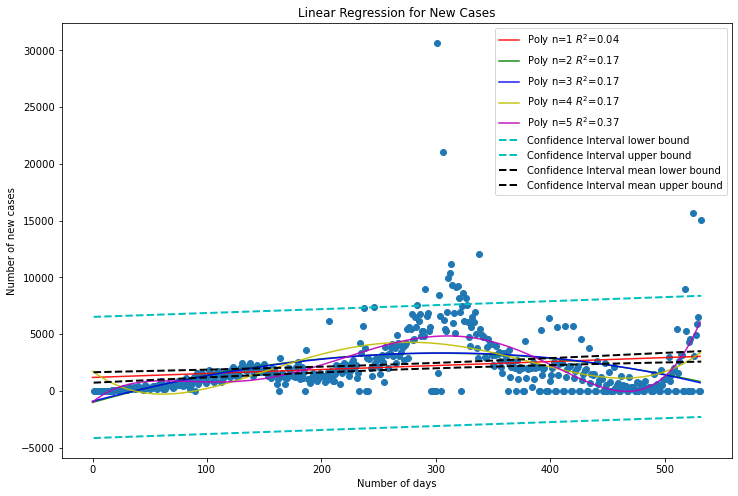

In [24]:
plt.figure(figsize=(12,8))
plt.scatter(abs(nc_super_df_firstcase['num_of_days']),abs(nc_super_df_firstcase['new_cases']))
plt.plot(y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % model1.rsquared, alpha=0.9)
plt.plot(y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % model2.rsquared, alpha=0.9)
plt.plot(y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % model3.rsquared, alpha=0.9)
plt.plot(y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % model3.rsquared, alpha=0.9)
plt.plot(y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % model5.rsquared, alpha=0.9)
# Plotting the upper and lower confidence intervals
summary, data, ci = summary_table(model1, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(nc_super_df_firstcase['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(nc_super_df_firstcase['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(nc_super_df_firstcase['num_of_days']), pd_mean_ci_low, 'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(nc_super_df_firstcase['num_of_days']), pd_mean_ci_upp, 'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

## Linear, Non-Linear Regression model and Confidence Intervals for number of new death cases across NORTH CAROLINA

In [25]:
model_death1, y_pred_d1 = generate_model(1,nc_super_df_first_deathcase,"death")
model_death2, y_pred_d2 = generate_model(2,nc_super_df_first_deathcase,"death")
model_death3, y_pred_d3 = generate_model(3,nc_super_df_first_deathcase,"death")
model_death4, y_pred_d4 = generate_model(4,nc_super_df_first_deathcase,"death")
model_death5, y_pred_d5 = generate_model(5,nc_super_df_first_deathcase,"death")

RMSE(Root Mean Square Error) value for the Linear model is:  37.5659332102488
RMSE(Root Mean Square Error) value for the Linear model is:  34.82223648964029
RMSE(Root Mean Square Error) value for the Linear model is:  34.603480646018056
RMSE(Root Mean Square Error) value for the Linear model is:  33.937224055660735
RMSE(Root Mean Square Error) value for the Linear model is:  33.08551201870659


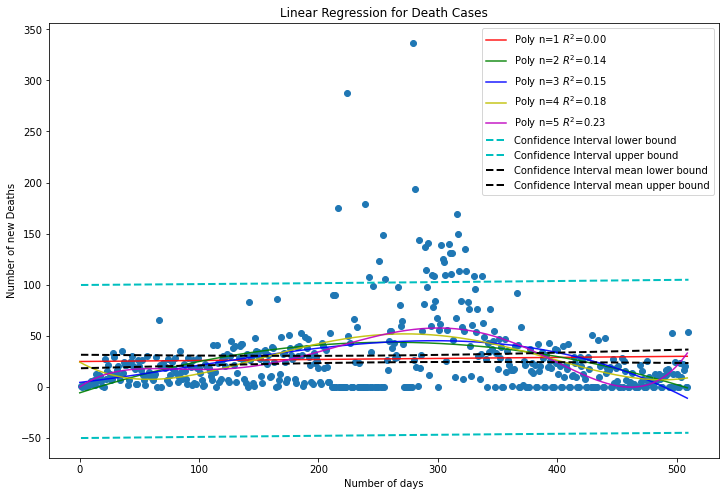

In [26]:
plt. figure(figsize=(12,8))
plt.scatter(abs(nc_super_df_first_deathcase['num_of_days']),abs(nc_super_df_first_deathcase['new_death_cases']))
plt.plot(y_pred_d1,c='r',label='Poly n=1 $R^2$=%.2f' % model_death1.rsquared, alpha=0.9)
plt.plot(y_pred_d2,c='g',label='Poly n=2 $R^2$=%.2f' % model_death2.rsquared, alpha=0.9)
plt.plot(y_pred_d3,c='b',label='Poly n=3 $R^2$=%.2f' % model_death3.rsquared, alpha=0.9)
plt.plot(y_pred_d4,c='y',label='Poly n=4 $R^2$=%.2f' % model_death4.rsquared, alpha=0.9)
plt.plot(y_pred_d5,c='m',label='Poly n=5 $R^2$=%.2f' % model_death5.rsquared, alpha=0.9)
summary, data, ci = summary_table(model_death1, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(nc_super_df_first_deathcase['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(nc_super_df_first_deathcase['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(nc_super_df_first_deathcase['num_of_days']), pd_mean_ci_low, 'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(nc_super_df_first_deathcase['num_of_days']), pd_mean_ci_upp, 'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new Deaths")
plt.legend()

## Plotting the trend line for NC new cases

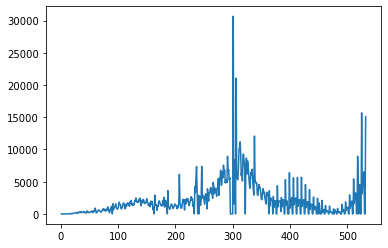

In [27]:
plt.plot(abs(nc_super_df_firstcase['num_of_days']),abs(nc_super_df_firstcase['new_cases']))

## Plotting trend lines for NC new death cases

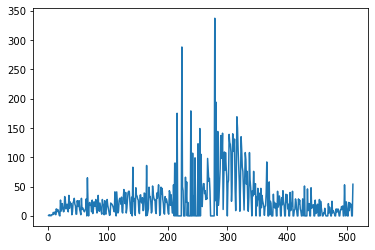

In [28]:
plt.plot(abs(nc_super_df_first_deathcase['num_of_days']),abs(nc_super_df_first_deathcase['new_death_cases']))

## Plot a trend line for next one week prediction for covid-19 new cases in NORTH CAROLINA
currently I am using Linear model to predict new cases in future, but we need to discuss on which is the best model and use that

In [29]:
# calculate the next 7 days input to x-axis and feed it to the model
def calculate_future_days(df):
    future_days = []
    future_days_df = ""
    for days in range((len(df)+1),(len(df)+7)):
        future_days.append(days)
        future_days_df = pd.DataFrame(future_days,columns=['num_of_days']) 
    return future_days_df

In [30]:
future_days_df = calculate_future_days(nc_super_df_firstcase)

In [31]:
predict_newcases = model1.predict(future_days_df['num_of_days'])

## Plot predictions for all models

In [32]:
def plot_preds(df,degree,key):
    pred_y = []
    model = ""
    if(degree==1 and key == 'new'):
        pred_y = model1.predict(df['num_of_days'])
    elif(degree==1 and key == 'death'):
        pred_y = model_death1.predict(df['num_of_days'])
    # Non-Linear model predictions
    if(degree>1):
        poly_features = PolynomialFeatures(degree=degree)
        x_preds = df['num_of_days']
        x_preds = smf.add_constant(x_preds)
        x_values = poly_features.fit_transform(x_preds)
        if(key == 'new'):
            model = globals()[f"model{degree}"]
        elif(key == 'death'):
            model = globals()[f"model_death{degree}"]
        pred_y = model.predict(x_values)
    return pred_y   

In [33]:
def return_polts(df,key):
    case_type = ''   
    if(key == 'new'):
        case_type = 'new'
    else:
        case_type = 'death'      
    degree1=plot_preds(df,1,case_type)
    degree2=plot_preds(df,2,case_type)
    degree3=plot_preds(df,3,case_type)
    degree4=plot_preds(df,4,case_type)
    degree5=plot_preds(df,5,case_type)   
    plt.plot(df['num_of_days'], degree1,label = "Degree1",color='red')
    plt.plot(df['num_of_days'], degree2,label = "Degree2", color='green')
    plt.plot(df['num_of_days'], degree3,label = "Degree3",color='pink')
    plt.plot(df['num_of_days'], degree4,label = "Degree4",color='blue')
    plt.legend()

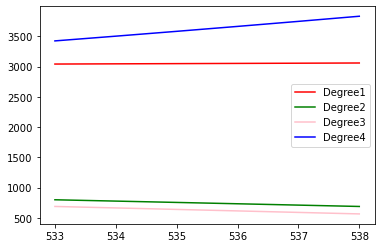

In [34]:
return_polts(future_days_df,'new')

## Plot a trend line for next one week prediction for covid-19 death new cases in NORTH CAROLINA

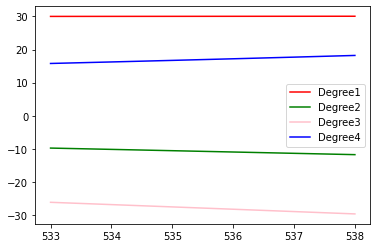

In [35]:
return_polts(future_days_df,'death')

## County Level Analysis - I have already found out the top five infected counties. I will fit the new cases per county and predict the next one week data for the county

In [36]:
covid_data_melt.tail() 

,CountyName,countyFIPS,State,StateFIPS,Date,new_cases
57195,Wayne County,37191,NC,37,2021-08-16,119.0
57196,Wilkes County,37193,NC,37,2021-08-16,111.0
57197,Wilson County,37195,NC,37,2021-08-16,75.0
57198,Yadkin County,37197,NC,37,2021-08-16,59.0
57199,Yancey County,37199,NC,37,2021-08-16,77.0


In [37]:
# selecting data for top 5 infected counties
rb_county = covid_data_melt[covid_data_melt['countyFIPS']==37155]
sm_county = covid_data_melt[covid_data_melt['countyFIPS']==37163]
hy_county = covid_data_melt[covid_data_melt['countyFIPS']==37095]
st_county = covid_data_melt[covid_data_melt['countyFIPS']==37167]
cl_county = covid_data_melt[covid_data_melt['countyFIPS']==37047]

In [38]:
rb_county_grp = rb_county.groupby(['Date'])['new_cases'].sum().reset_index()
sm_county_grp = sm_county.groupby(['Date'])['new_cases'].sum().reset_index()
hy_county_grp = hy_county.groupby(['Date'])['new_cases'].sum().reset_index()
st_county_grp = st_county.groupby(['Date'])['new_cases'].sum().reset_index()
cl_county_grp = cl_county.groupby(['Date'])['new_cases'].sum().reset_index()

In [39]:
rb_county_grp.tail()

,Date,new_cases
567,2021-08-12,120.0
568,2021-08-13,137.0
569,2021-08-14,0.0
570,2021-08-15,0.0
571,2021-08-16,292.0


In [40]:
def calculate_days(df):
    df.index += 1
    df['num_of_days'] = df.index
    return df

In [41]:
rb_newdf = calculate_days(rb_county_grp)
sm_newdf = calculate_days(sm_county_grp)
hy_newdf = calculate_days(hy_county_grp)
st_newdf = calculate_days(st_county_grp)
cl_newdf = calculate_days(cl_county_grp)

In [42]:
rb_newdf.tail()

,Date,new_cases,num_of_days
568,2021-08-12,120.0,568
569,2021-08-13,137.0,569
570,2021-08-14,0.0,570
571,2021-08-15,0.0,571
572,2021-08-16,292.0,572


In [43]:
c_model1, c_y_pred1 = generate_model(1,rb_newdf,'new')
c_model2, c_y_pred2 = generate_model(2,rb_newdf,"new")
c_model3, c_y_pred3 = generate_model(3,rb_newdf,"new")
c_model4, c_y_pred4 = generate_model(4,rb_newdf,"new")
c_model5, c_y_pred5 = generate_model(5,rb_newdf,"new")

RMSE(Root Mean Square Error) value for the Linear model is:  51.72806930959625
RMSE(Root Mean Square Error) value for the Linear model is:  49.860464976861806
RMSE(Root Mean Square Error) value for the Linear model is:  49.78251825074421
RMSE(Root Mean Square Error) value for the Linear model is:  47.10809784207688
RMSE(Root Mean Square Error) value for the Linear model is:  45.26160578595978


## Robeson County Regression model 

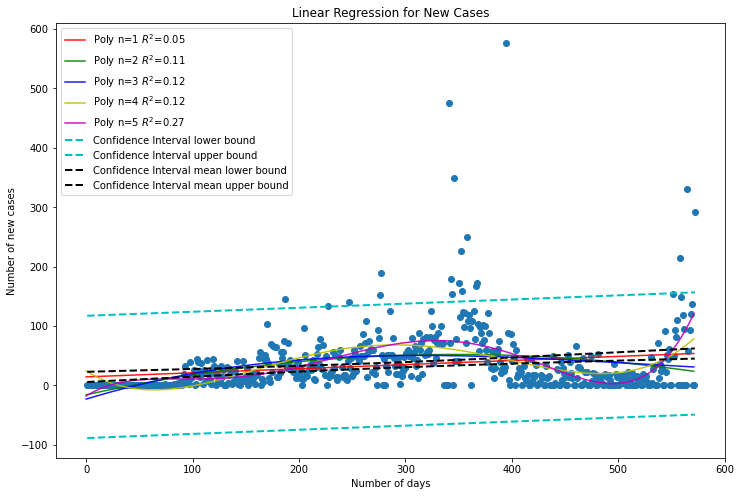

In [44]:
plt. figure(figsize=(12,8))
plt.scatter(rb_newdf['num_of_days'],abs(rb_newdf['new_cases']))
plt.plot(c_y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % c_model1.rsquared, alpha=0.9)
plt.plot(c_y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % c_model2.rsquared, alpha=0.9)
plt.plot(c_y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % c_model3.rsquared, alpha=0.9)
plt.plot(c_y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % c_model3.rsquared, alpha=0.9)
plt.plot(c_y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % c_model5.rsquared, alpha=0.9)
summary, data, ci = summary_table(c_model1, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(rb_newdf['num_of_days']), pd_ci_low, 'c--', lw=2,label = "Confidence Interval lower bound")
plt.plot(abs(rb_newdf['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(rb_newdf['num_of_days']), pd_mean_ci_low, 'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(rb_newdf['num_of_days']), pd_mean_ci_upp, 'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

## Trend Line for Robeson County

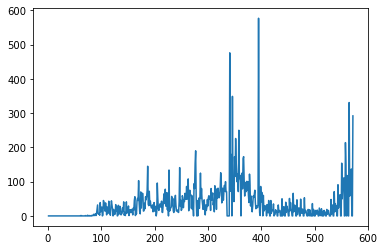

In [45]:
plt.plot(rb_newdf['num_of_days'],abs(rb_newdf['new_cases']))

In [46]:
future_days_counties = calculate_future_days(rb_newdf)

In [47]:
def plot_preds_county(df,degree,key,county):
    pred_y = []
    model = ""
    if(degree==1 and key == 'new'):
        model1 = globals()[f"{county}_model{degree}"]
        pred_y = model1.predict(df['num_of_days'])
    elif(degree==1 and key == 'death'):
        model1 = globals()[f"{county}_model{degree}"]
        pred_y = model_death1.predict(df['num_of_days'])
    # Non-Linear model predictions
    if(degree>1):
        poly_features = PolynomialFeatures(degree=degree)
        x_preds = df['num_of_days']
        x_preds = smf.add_constant(x_preds)
        x_values = poly_features.fit_transform(x_preds)
        if(key == 'new'):
            model = globals()[f"{county}_model{degree}"]
        elif(key == 'death'):
            model = globals()[f"{county}_model{degree}"]
        pred_y = model.predict(x_values)
    return pred_y   

In [48]:
def return_polts_county(df,key,county):
    case_type = ''   
    if(key == 'new'):
        case_type = 'new'
    else:
        case_type = 'death'      
    degree1=plot_preds_county(df,1,case_type,county)
    degree2=plot_preds_county(df,2,case_type,county)
    degree3=plot_preds_county(df,3,case_type,county)
    degree4=plot_preds_county(df,4,case_type,county)
    degree5=plot_preds_county(df,5,case_type,county)   
    plt.plot(df['num_of_days'], degree1,label = "Degree1",color='red')
    plt.plot(df['num_of_days'], degree2,label = "Degree2", color='green')
    plt.plot(df['num_of_days'], degree3,label = "Degree3",color='pink')
    plt.plot(df['num_of_days'], degree4,label = "Degree4",color='blue')
    plt.legend()

## Prediction Line for Robeson County upto 4 degrees

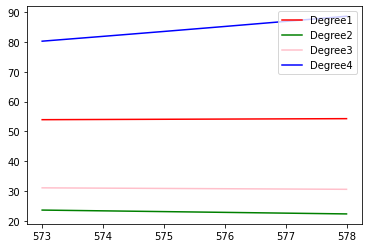

In [49]:
# rb_future_cases = c_model1.predict(future_days_counties['num_of_days'])
# plt.plot(future_days_counties['num_of_days'],rb_future_cases)
return_polts_county(future_days_counties,'new','c')

## Sampson County

In [50]:
sampson_model1, s_y_pred1 = generate_model(1,sm_newdf,'new')
sampson_model2, s_y_pred2 = generate_model(2,sm_newdf,"new")
sampson_model3, s_y_pred3 = generate_model(3,sm_newdf,"new")
sampson_model4, s_y_pred4 = generate_model(4,sm_newdf,"new")
sampson_model5, s_y_pred5 = generate_model(5,sm_newdf,"new")

RMSE(Root Mean Square Error) value for the Linear model is:  26.235272344950076
RMSE(Root Mean Square Error) value for the Linear model is:  25.184218003948985
RMSE(Root Mean Square Error) value for the Linear model is:  25.18408252679514
RMSE(Root Mean Square Error) value for the Linear model is:  24.619794571069956
RMSE(Root Mean Square Error) value for the Linear model is:  23.991635874894286


## Linear, Non-Linear Regression and Confidence intervals

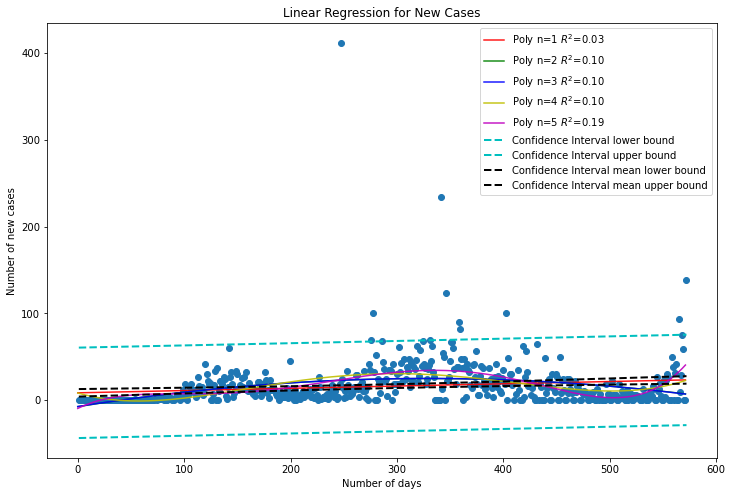

No handles with labels found to put in legend.


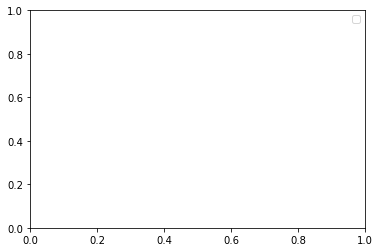

In [51]:
plt. figure(figsize=(12,8))
plt.scatter(sm_newdf['num_of_days'],abs(sm_newdf['new_cases']))
plt.plot(s_y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % sampson_model1.rsquared, alpha=0.9)
plt.plot(s_y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % sampson_model2.rsquared, alpha=0.9)
plt.plot(s_y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % sampson_model3.rsquared, alpha=0.9)
plt.plot(s_y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % sampson_model3.rsquared, alpha=0.9)
plt.plot(s_y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % sampson_model5.rsquared, alpha=0.9)
summary, data, ci = summary_table(sampson_model1, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(sm_newdf['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(sm_newdf['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(sm_newdf['num_of_days']), pd_mean_ci_low,'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(sm_newdf['num_of_days']), pd_mean_ci_upp,'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

## Trend Line for Sampson County

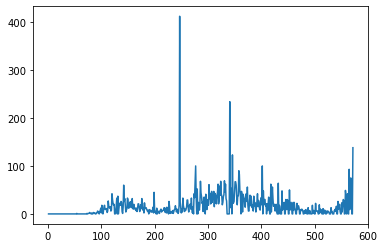

In [52]:
plt.plot(sm_newdf['num_of_days'],abs(sm_newdf['new_cases']))

## Prediction Line for Sampson County upto 4 degrees

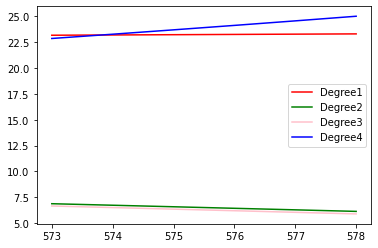

In [53]:
# sp_future_cases = sampson_model1.predict(future_days_counties['num_of_days'])
# plt.plot(future_days_counties['num_of_days'],sp_future_cases)
return_polts_county(future_days_counties,'new','sampson')

## Regression model for Hyde County

In [54]:
hy_model1, hy_y_pred1 = generate_model(1,hy_newdf,'new')
hy_model2, hy_y_pred2 = generate_model(2,hy_newdf,"new")
hy_model3, hy_y_pred3 = generate_model(3,hy_newdf,"new")
hy_model4, hy_y_pred4 = generate_model(4,hy_newdf,"new")
hy_model5, hy_y_pred5 = generate_model(5,hy_newdf,"new")

RMSE(Root Mean Square Error) value for the Linear model is:  4.174578041119467
RMSE(Root Mean Square Error) value for the Linear model is:  4.066509723966851
RMSE(Root Mean Square Error) value for the Linear model is:  4.048768052120771
RMSE(Root Mean Square Error) value for the Linear model is:  4.009283147608418
RMSE(Root Mean Square Error) value for the Linear model is:  3.9695632542075394


## Linear, Non-Linear Regression and Confidence intervals

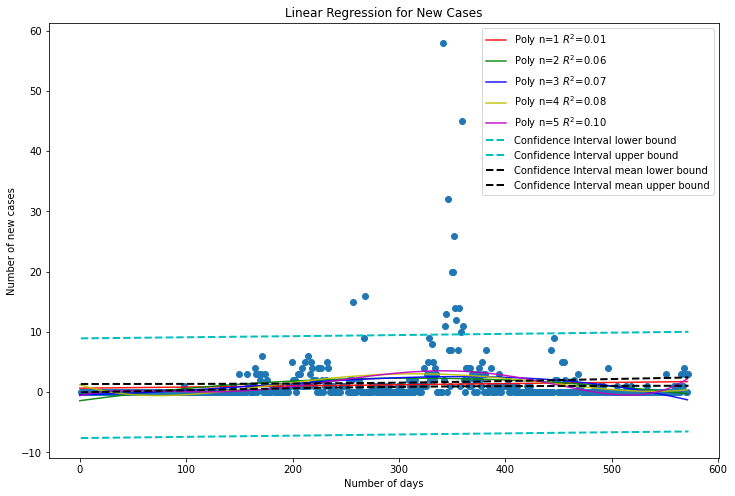

In [55]:
plt. figure(figsize=(12,8))
plt.scatter(hy_newdf['num_of_days'],abs(hy_newdf['new_cases']))
plt.plot(hy_y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % hy_model1.rsquared, alpha=0.9)
plt.plot(hy_y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % hy_model2.rsquared, alpha=0.9)
plt.plot(hy_y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % hy_model3.rsquared, alpha=0.9)
plt.plot(hy_y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % hy_model4.rsquared, alpha=0.9)
plt.plot(hy_y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % hy_model5.rsquared, alpha=0.9)
summary, data, ci = summary_table(hy_model1, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(hy_newdf['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(hy_newdf['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(hy_newdf['num_of_days']), pd_mean_ci_low,'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(hy_newdf['num_of_days']), pd_mean_ci_upp,'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

## Trend Line for Hyde County

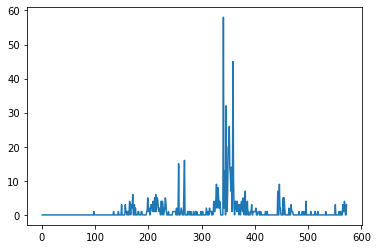

In [56]:
plt.plot(hy_newdf['num_of_days'],abs(hy_newdf['new_cases']))

## Prediction Line for Hyde County upto 4 degrees

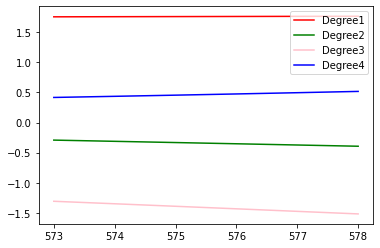

In [57]:
# hy_future_cases = hy_model1.predict(future_days_counties['num_of_days'])
# plt.plot(future_days_counties['num_of_days'],hy_future_cases)
return_polts_county(future_days_counties,'new','hy')

## Regression model for Stanly County

In [58]:
st_model1, st_y_pred1 = generate_model(1,st_newdf,'new')
st_model2, st_y_pred2 = generate_model(2,st_newdf,"new")
st_model3, st_y_pred3 = generate_model(3,st_newdf,"new")
st_model4, st_y_pred4 = generate_model(4,st_newdf,"new")
st_model5, st_y_pred5 = generate_model(5,st_newdf,"new")

RMSE(Root Mean Square Error) value for the Linear model is:  21.223693726546564
RMSE(Root Mean Square Error) value for the Linear model is:  19.680878986649148
RMSE(Root Mean Square Error) value for the Linear model is:  19.63804369542005
RMSE(Root Mean Square Error) value for the Linear model is:  18.648431828232116
RMSE(Root Mean Square Error) value for the Linear model is:  17.74985096801876


## Linear, Non-Linear Regression and Confidence intervals

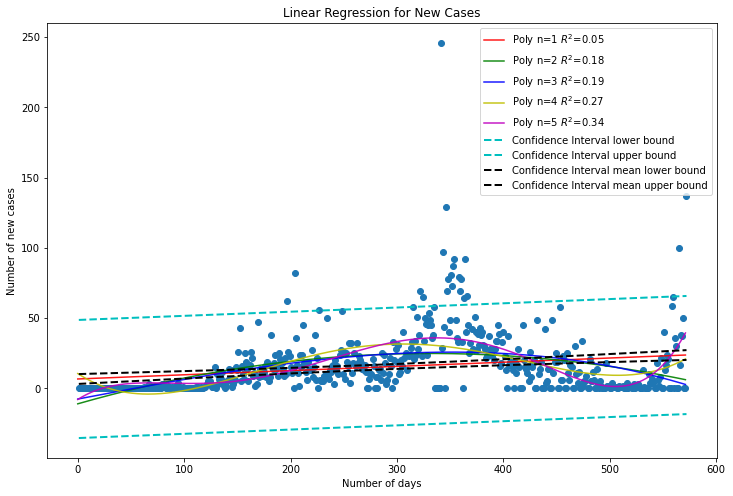

In [59]:
plt. figure(figsize=(12,8))
plt.scatter(st_newdf['num_of_days'],abs(st_newdf['new_cases']))
plt.plot(st_y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % st_model1.rsquared, alpha=0.9)
plt.plot(st_y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % st_model2.rsquared, alpha=0.9)
plt.plot(st_y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % st_model3.rsquared, alpha=0.9)
plt.plot(st_y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % st_model4.rsquared, alpha=0.9)
plt.plot(st_y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % st_model5.rsquared, alpha=0.9)
summary, data, ci = summary_table(st_model1, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(st_newdf['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(st_newdf['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(st_newdf['num_of_days']), pd_mean_ci_low,'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(st_newdf['num_of_days']), pd_mean_ci_upp,'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

## Trend Line for Stanly County

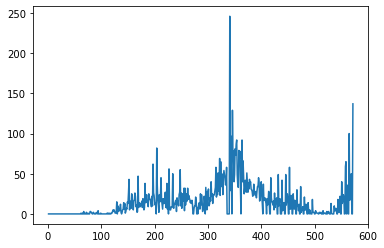

In [60]:
plt.plot(st_newdf['num_of_days'],abs(st_newdf['new_cases']))

## Prediction Line for Stanly County upto 4 degrees

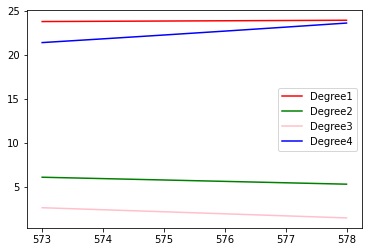

In [61]:
# st_future_cases = st_model1.predict(future_days_counties['num_of_days'])
# plt.plot(future_days_counties['num_of_days'],st_future_cases)
return_polts_county(future_days_counties,'new','st')

## Regression model for Columbus County

In [62]:
co_model1, co_y_pred1 = generate_model(1,cl_newdf,'new')
co_model2, co_y_pred2 = generate_model(2,cl_newdf,"new")
co_model3, co_y_pred3 = generate_model(3,cl_newdf,"new")
co_model4, co_y_pred4 = generate_model(4,cl_newdf,"new")
co_model5, co_y_pred5 = generate_model(5,cl_newdf,"new")

RMSE(Root Mean Square Error) value for the Linear model is:  21.996836851853985
RMSE(Root Mean Square Error) value for the Linear model is:  21.487217744667785
RMSE(Root Mean Square Error) value for the Linear model is:  21.47334557860171
RMSE(Root Mean Square Error) value for the Linear model is:  20.086197415080406
RMSE(Root Mean Square Error) value for the Linear model is:  18.570555490215295


## Linear, Non-Linear Regression and Confidence intervals

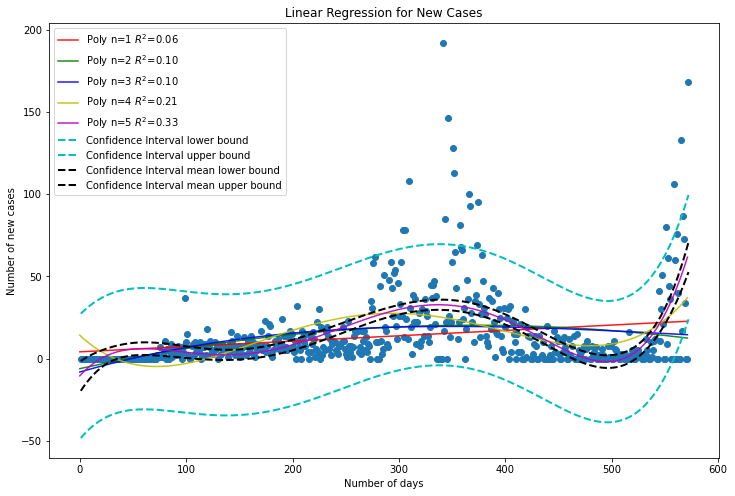

In [63]:
plt. figure(figsize=(12,8))
plt.scatter(cl_newdf['num_of_days'],abs(cl_newdf['new_cases']))
plt.plot(co_y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % co_model1.rsquared, alpha=0.9)
plt.plot(co_y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % co_model2.rsquared, alpha=0.9)
plt.plot(co_y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % co_model3.rsquared, alpha=0.9)
plt.plot(co_y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % co_model4.rsquared, alpha=0.9)
plt.plot(co_y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % co_model5.rsquared, alpha=0.9)
summary, data, ci = summary_table(co_model5, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(cl_newdf['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(cl_newdf['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(cl_newdf['num_of_days']), pd_mean_ci_low,'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(cl_newdf['num_of_days']), pd_mean_ci_upp,'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for New Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of new cases")
plt.legend()
plt.show("png")

## Trend Line for Columbus County

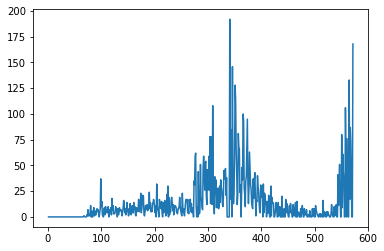

In [64]:
plt.plot(cl_newdf['num_of_days'],abs(cl_newdf['new_cases']))

## Prediction Line for Columbus County upto 4 degrees

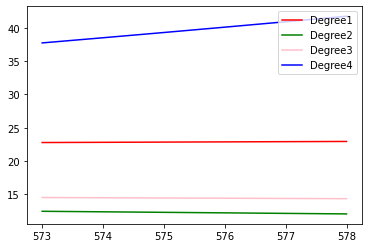

In [65]:
# sp_future_cases = co_model1.predict(future_days_counties['num_of_days'])
# plt.plot(future_days_counties['num_of_days'],sp_future_cases)
return_polts_county(future_days_counties,'new','co')

## Modelling and Predictions for Top 5 Covid Death Counties in NC

In [66]:
# selecting data for top 5 infected counties
mo_county = covid_data_death_melt[covid_data_death_melt['countyFIPS']==37123]
ru_county = covid_data_death_melt[covid_data_death_melt['countyFIPS']==37161]
nh_county = covid_data_death_melt[covid_data_death_melt['countyFIPS']==37131]
jo_county = covid_data_death_melt[covid_data_death_melt['countyFIPS']==37103]
col_county = covid_data_death_melt[covid_data_death_melt['countyFIPS']==37047]

In [67]:
mo_county_grp = mo_county.groupby(['Date'])['new_death_cases'].sum().reset_index()
ru_county_grp = ru_county.groupby(['Date'])['new_death_cases'].sum().reset_index()
nh_county_grp = nh_county.groupby(['Date'])['new_death_cases'].sum().reset_index()
jo_county_grp = jo_county.groupby(['Date'])['new_death_cases'].sum().reset_index()
col_county_grp = col_county.groupby(['Date'])['new_death_cases'].sum().reset_index()

In [68]:
mo_newdf = calculate_days(mo_county_grp)
ru_newdf = calculate_days(ru_county_grp)
nh_newdf = calculate_days(nh_county_grp)
jo_newdf = calculate_days(jo_county_grp)
col_newdf = calculate_days(col_county_grp)

## Montgomery County

In [69]:
mo_model1, mo_y_pred1 = generate_model(1,mo_newdf,'death')
mo_model2, mo_y_pred2 = generate_model(2,mo_newdf,"death")
mo_model3, mo_y_pred3 = generate_model(3,mo_newdf,"death")
mo_model4, mo_y_pred4 = generate_model(4,mo_newdf,"death")
mo_model5, mo_y_pred5 = generate_model(5,mo_newdf,"death")

RMSE(Root Mean Square Error) value for the Linear model is:  0.5453603774600273
RMSE(Root Mean Square Error) value for the Linear model is:  0.5320188404986849
RMSE(Root Mean Square Error) value for the Linear model is:  0.530321962751363
RMSE(Root Mean Square Error) value for the Linear model is:  0.5295829256096504
RMSE(Root Mean Square Error) value for the Linear model is:  0.5282907142806009


## Linear, Non-Linear Regression and Confidence intervals

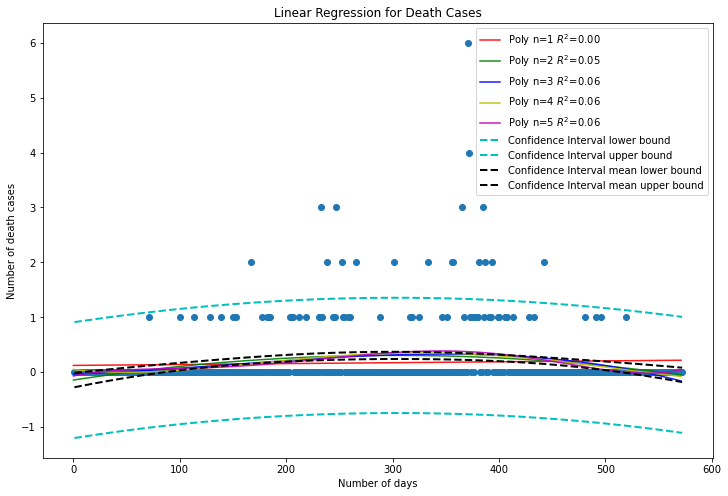

In [70]:
plt. figure(figsize=(12,8))
plt.scatter(mo_newdf['num_of_days'],abs(mo_newdf['new_death_cases']))
plt.plot(mo_y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % mo_model1.rsquared, alpha=0.9)
plt.plot(mo_y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % mo_model2.rsquared, alpha=0.9)
plt.plot(mo_y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % mo_model3.rsquared, alpha=0.9)
plt.plot(mo_y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % mo_model4.rsquared, alpha=0.9)
plt.plot(mo_y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % mo_model5.rsquared, alpha=0.9)
summary, data, ci = summary_table(mo_model2, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(mo_newdf['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(mo_newdf['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(mo_newdf['num_of_days']), pd_mean_ci_low,'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(mo_newdf['num_of_days']), pd_mean_ci_upp,'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of death cases")
plt.legend()
plt.show("png")

## Trend Line for Montgomery County

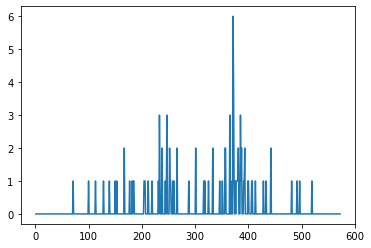

In [71]:
plt.plot(mo_newdf['num_of_days'],abs(mo_newdf['new_death_cases']))

## Prediction Line for Montgomery County upto 4 degrees

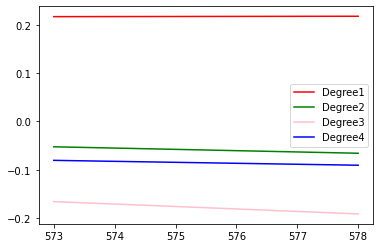

In [72]:
# mo_future_cases = mo_model1.predict(future_days_counties['num_of_days'])
# plt.plot(future_days_counties['num_of_days'],mo_future_cases)
return_polts_county(future_days_counties,'new','mo')

## Rutherford County

In [73]:
rf_model1, rf_y_pred1 = generate_model(1,ru_newdf,'death')
rf_model2, rf_y_pred2 = generate_model(2,ru_newdf,"death")
rf_model3, rf_y_pred3 = generate_model(3,ru_newdf,"death")
rf_model4, rf_y_pred4 = generate_model(4,ru_newdf,"death")
rf_model5, rf_y_pred5 = generate_model(5,ru_newdf,"death")

RMSE(Root Mean Square Error) value for the Linear model is:  1.4541745823427596
RMSE(Root Mean Square Error) value for the Linear model is:  1.4252479032547591
RMSE(Root Mean Square Error) value for the Linear model is:  1.4175556679918164
RMSE(Root Mean Square Error) value for the Linear model is:  1.408208176086088
RMSE(Root Mean Square Error) value for the Linear model is:  1.3979938279271917


## Linear, Non-Linear Regression and Confidence intervals

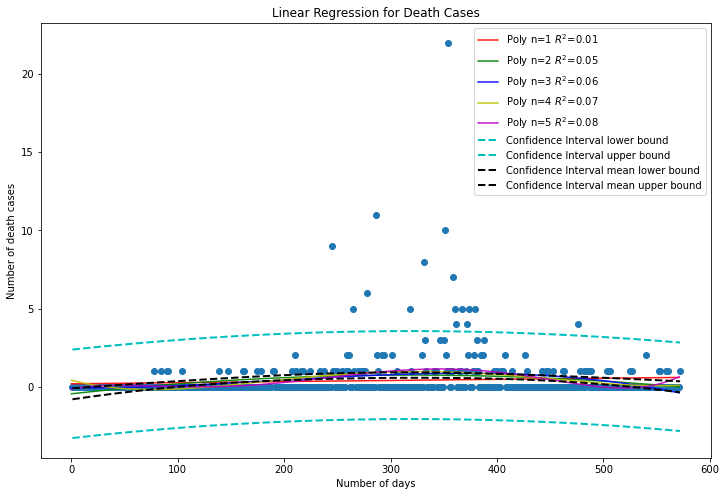

In [74]:
plt. figure(figsize=(12,8))
plt.scatter(ru_newdf['num_of_days'],abs(ru_newdf['new_death_cases']))
plt.plot(rf_y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % rf_model1.rsquared, alpha=0.9)
plt.plot(rf_y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % rf_model2.rsquared, alpha=0.9)
plt.plot(rf_y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % rf_model3.rsquared, alpha=0.9)
plt.plot(rf_y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % rf_model4.rsquared, alpha=0.9)
plt.plot(rf_y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % rf_model5.rsquared, alpha=0.9)
summary, data, ci = summary_table(rf_model2, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(ru_newdf['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(ru_newdf['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(ru_newdf['num_of_days']), pd_mean_ci_low,'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(ru_newdf['num_of_days']), pd_mean_ci_upp,'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of death cases")
plt.legend()
plt.show("png")

## Trend Line for Rutherford County

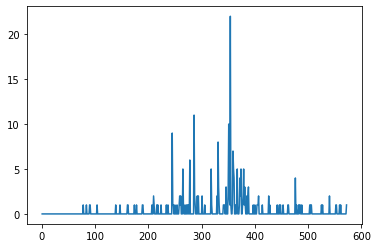

In [75]:
plt.plot(ru_newdf['num_of_days'],abs(ru_newdf['new_death_cases']))

## Prediction Line for Rutherford County upto 4 degrees

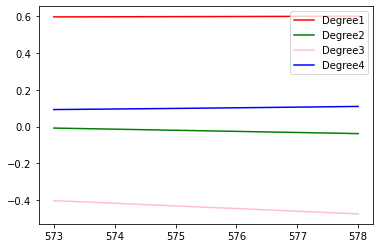

In [76]:
# rf_future_cases = rf_model1.predict(future_days_counties['num_of_days'])
# plt.plot(future_days_counties['num_of_days'],rf_future_cases)
return_polts_county(future_days_counties,'new','rf')

## Northhampton County

In [77]:
nh_model1, nh_y_pred1 = generate_model(1,nh_newdf,'death')
nh_model2, nh_y_pred2 = generate_model(2,nh_newdf,"death")
nh_model3, nh_y_pred3 = generate_model(3,nh_newdf,"death")
nh_model4, nh_y_pred4 = generate_model(4,nh_newdf,"death")
nh_model5, nh_y_pred5 = generate_model(5,nh_newdf,"death")

RMSE(Root Mean Square Error) value for the Linear model is:  0.4760491390562749
RMSE(Root Mean Square Error) value for the Linear model is:  0.4753643630761284
RMSE(Root Mean Square Error) value for the Linear model is:  0.4741993718804374
RMSE(Root Mean Square Error) value for the Linear model is:  0.4695848535424539
RMSE(Root Mean Square Error) value for the Linear model is:  0.4695395622465234


## Linear, Non-Linear Regression and Confidence intervals

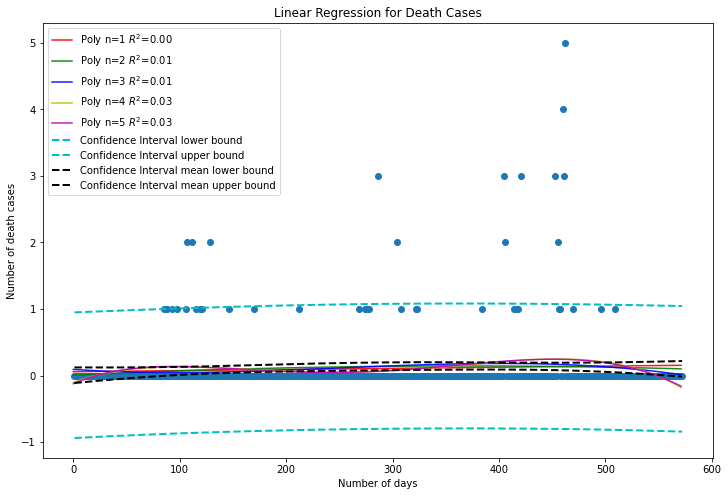

In [78]:
plt. figure(figsize=(12,8))
plt.scatter(nh_newdf['num_of_days'],abs(nh_newdf['new_death_cases']))
plt.plot(nh_y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % nh_model1.rsquared, alpha=0.9)
plt.plot(nh_y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % nh_model2.rsquared, alpha=0.9)
plt.plot(nh_y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % nh_model3.rsquared, alpha=0.9)
plt.plot(nh_y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % nh_model4.rsquared, alpha=0.9)
plt.plot(nh_y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % nh_model5.rsquared, alpha=0.9)
summary, data, ci = summary_table(nh_model2, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(nh_newdf['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(nh_newdf['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(nh_newdf['num_of_days']), pd_mean_ci_low,'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(nh_newdf['num_of_days']), pd_mean_ci_upp,'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of death cases")
plt.legend()
plt.show("png")

## Trend Line for Northhampton County

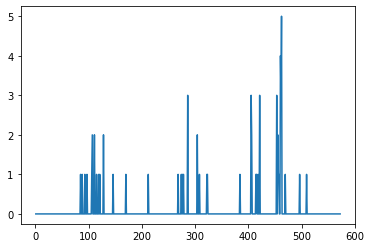

In [79]:
plt.plot(nh_newdf['num_of_days'],abs(nh_newdf['new_death_cases']))

## Prediction Line for Northampton County upto 4 degrees

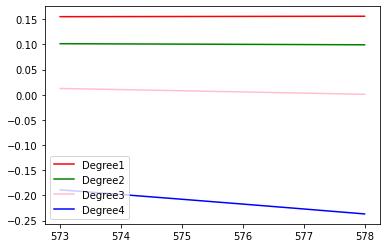

In [80]:
# nh_future_cases = nh_model1.predict(future_days_counties['num_of_days'])
# plt.plot(future_days_counties['num_of_days'],nh_future_cases)
return_polts_county(future_days_counties,'new','nh')

## Jones County

In [81]:
jo_model1, jo_y_pred1 = generate_model(1,jo_newdf,'death')
jo_model2, jo_y_pred2 = generate_model(2,jo_newdf,"death")
jo_model3, jo_y_pred3 = generate_model(3,jo_newdf,"death")
jo_model4, jo_y_pred4 = generate_model(4,jo_newdf,"death")
jo_model5, jo_y_pred5 = generate_model(5,jo_newdf,"death")

RMSE(Root Mean Square Error) value for the Linear model is:  0.40354311164014267
RMSE(Root Mean Square Error) value for the Linear model is:  0.4033806332257609
RMSE(Root Mean Square Error) value for the Linear model is:  0.4033741321986427
RMSE(Root Mean Square Error) value for the Linear model is:  0.4030462911695397
RMSE(Root Mean Square Error) value for the Linear model is:  0.40185850344879165


## Linear, Non-Linear Regression and Confidence intervals

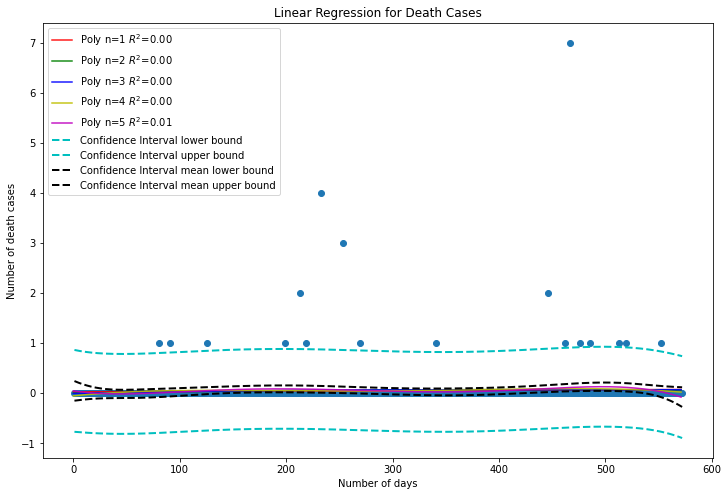

In [82]:
plt. figure(figsize=(12,8))
plt.scatter(jo_newdf['num_of_days'],abs(jo_newdf['new_death_cases']))
plt.plot(jo_y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % jo_model1.rsquared, alpha=0.9)
plt.plot(jo_y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % jo_model2.rsquared, alpha=0.9)
plt.plot(jo_y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % jo_model3.rsquared, alpha=0.9)
plt.plot(jo_y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % jo_model4.rsquared, alpha=0.9)
plt.plot(jo_y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % jo_model5.rsquared, alpha=0.9)
summary, data, ci = summary_table(jo_model5, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(jo_newdf['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(jo_newdf['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(jo_newdf['num_of_days']), pd_mean_ci_low,'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(jo_newdf['num_of_days']), pd_mean_ci_upp,'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of death cases")
plt.legend()
plt.show("png")

## Trend Line for Jones County

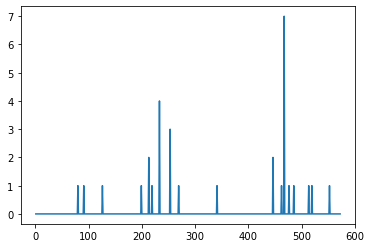

In [83]:
plt.plot(jo_newdf['num_of_days'],abs(jo_newdf['new_death_cases']))

## Prediction Line for Jones County upto 4 degrees

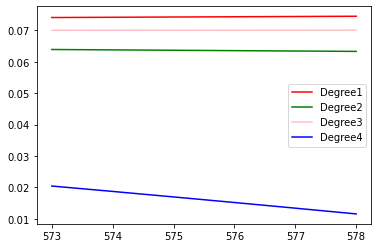

In [84]:
# jo_future_cases = jo_model1.predict(future_days_counties['num_of_days'])
# plt.plot(future_days_counties['num_of_days'],jo_future_cases)
return_polts_county(future_days_counties,'new','jo')

## Columbus county

In [85]:
col_model1, col_y_pred1 = generate_model(1,col_newdf,'death')
col_model2, col_y_pred2 = generate_model(2,col_newdf,"death")
col_model3, col_y_pred3 = generate_model(3,col_newdf,"death")
col_model4, col_y_pred4 = generate_model(4,col_newdf,"death")
col_model5, col_y_pred5 = generate_model(5,col_newdf,"death")

RMSE(Root Mean Square Error) value for the Linear model is:  0.8006020560361994
RMSE(Root Mean Square Error) value for the Linear model is:  0.7908255161304796
RMSE(Root Mean Square Error) value for the Linear model is:  0.7907730398346036
RMSE(Root Mean Square Error) value for the Linear model is:  0.7906503023507315
RMSE(Root Mean Square Error) value for the Linear model is:  0.7786064561604132


## Linear, Non-Linear Regression and Confidence intervals

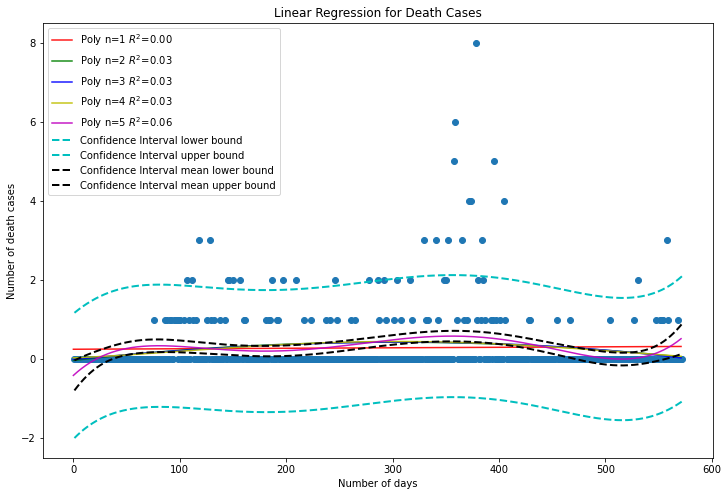

In [86]:
plt. figure(figsize=(12,8))
plt.scatter(col_newdf['num_of_days'],abs(col_newdf['new_death_cases']))
plt.plot(col_y_pred1,c='r',label='Poly n=1 $R^2$=%.2f' % col_model1.rsquared, alpha=0.9)
plt.plot(col_y_pred2,c='g',label='Poly n=2 $R^2$=%.2f' % col_model2.rsquared, alpha=0.9)
plt.plot(col_y_pred3,c='b',label='Poly n=3 $R^2$=%.2f' % col_model3.rsquared, alpha=0.9)
plt.plot(col_y_pred4,c='y',label='Poly n=4 $R^2$=%.2f' % col_model4.rsquared, alpha=0.9)
plt.plot(col_y_pred5,c='m',label='Poly n=5 $R^2$=%.2f' % col_model5.rsquared, alpha=0.9)
summary, data, ci = summary_table(col_model5, alpha=0.05)
pd_mean_ci_low, pd_mean_ci_upp = data[:, 4:6].T
pd_ci_low, pd_ci_upp = data[:, 6:8].T
plt.plot(abs(col_newdf['num_of_days']), pd_ci_low, 'c--', lw=2, label = "Confidence Interval lower bound")
plt.plot(abs(col_newdf['num_of_days']), pd_ci_upp, 'c--', lw=2, label = "Confidence Interval upper bound")
plt.plot(abs(col_newdf['num_of_days']), pd_mean_ci_low,'k--', lw=2, label = "Confidence Interval mean lower bound")
plt.plot(abs(col_newdf['num_of_days']), pd_mean_ci_upp,'k--', lw=2, label = "Confidence Interval mean upper bound")
plt.title("Linear Regression for Death Cases")
plt.xlabel("Number of days")
plt.ylabel("Number of death cases")
plt.legend()
plt.show("png")

## Trend Line for Columbus County

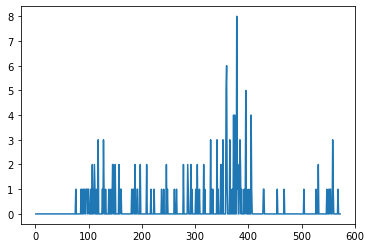

In [87]:
plt.plot(col_newdf['num_of_days'],abs(col_newdf['new_death_cases']))

## Prediction Line for Columbus County upto 4 degrees

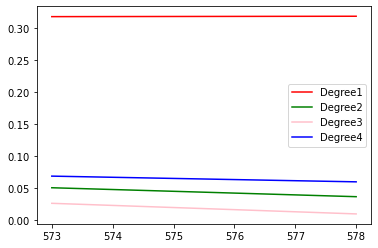

In [88]:
# col_future_cases = co_model1.predict(future_days_counties['num_of_days'])
# plt.plot(future_days_counties['num_of_days'],col_future_cases)
return_polts_county(future_days_counties,'new','col')

## Confidence Intervals
#### Confidence interval for Linear-Model

In [89]:
print("NC state's Confidence interval",model1.conf_int())

NC state's Confidence interval                       0            1
Intercept    715.865251  1639.542676
num_of_days    1.995957     4.998972


## Confidence intervals for number of death cases in NC

In [90]:
print("NC state's death Confidence interval",model_death1.conf_int())

NC state's death Confidence interval                      0          1
Intercept    18.020462  31.267215
num_of_days  -0.012395   0.032527


#### Top 5 infected counties Confidence intervals for Linear model - everyday new cases

In [91]:
print("Robeson County Confidence interval",c_model1.conf_int())
print('-------------------------------------------------------')
print("Sampson county Confidence interval",sampson_model1.conf_int())
print('-------------------------------------------------------')
print("Hyde County Confidence interval",hy_model1.conf_int())
print('-------------------------------------------------------')
print("Stanly County Confidence interval",st_model1.conf_int())
print('-------------------------------------------------------')
print("Columbus County Confidence interval",co_model1.conf_int())

Robeson County Confidence interval                     0          1
Intercept    5.817222  22.991640
num_of_days  0.043001   0.094939
-------------------------------------------------------
Sampson county Confidence interval                     0          1
Intercept    3.876744  12.577275
num_of_days  0.012901   0.039213
-------------------------------------------------------
Hyde County Confidence interval                     0         1
Intercept   -0.030564  1.349707
num_of_days -0.000179  0.003995
-------------------------------------------------------
Stanly County Confidence interval                     0          1
Intercept    3.182699  10.194997
num_of_days  0.019236   0.040442
-------------------------------------------------------
Columbus County Confidence interval                     0         1
Intercept    0.481387  7.778775
num_of_days  0.021518  0.043586


#### Top 5 infected counties Confidence intervals for Linear model - Death Cases

In [92]:
print("Montgomery County  Confidence interval",mo_model1.conf_int())
print('-------------------------------------------------------')
print("Rutherford County Confidence interval",rf_model1.conf_int())
print('-------------------------------------------------------')
print("Northampton County Confidence interval",nh_model1.conf_int())
print('-------------------------------------------------------')
print("Jones County Confidence interval",jo_model1.conf_int())
print('-------------------------------------------------------')
print("Columbus County Confidence interval",co_model1.conf_int())

Montgomery County  Confidence interval                     0         1
Intercept    0.032289  0.211989
num_of_days -0.000106  0.000437
-------------------------------------------------------
Rutherford County Confidence interval                     0         1
Intercept   -0.051762  0.429568
num_of_days -0.000014  0.001441
-------------------------------------------------------
Northampton County Confidence interval                     0         1
Intercept   -0.020421  0.136694
num_of_days -0.000068  0.000407
-------------------------------------------------------
Jones County Confidence interval                     0         1
Intercept   -0.039316  0.093852
num_of_days -0.000120  0.000283
-------------------------------------------------------
Columbus County Confidence interval                     0         1
Intercept    0.481387  7.778775
num_of_days  0.021518  0.043586


## Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

## Fetch the hospital bed dataset

In [93]:
hospital_bed_data = pd.read_csv('..\..\..\..\data\stage_3\Definitive_Healthcare%3A_USA_Hospital_Beds.csv')
hospital_bed_data = hospital_bed_data[hospital_bed_data['FIPS'].notna()]
hospital_bed_data = hospital_bed_data.fillna(0)
hospital_bed_data = hospital_bed_data.astype({'FIPS': 'int','NUM_LICENSED_BEDS':'int','NUM_STAFFED_BEDS':'int','PEDI_ICU_BEDS':'int'})
hospital_bed = hospital_bed_data[hospital_bed_data['HQ_STATE']=='NC']
hospital_bed

,X,Y,OBJECTID,HOSPITAL_NAME,HOSPITAL_TYPE,HQ_ADDRESS,HQ_ADDRESS1,HQ_CITY,HQ_STATE,HQ_ZIP_CODE,...,CNTY_FIPS,FIPS,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
1740,-79.503140,36.061463,2741,Cone Health Alamance Regional Medical Center (...,Short Term Acute Care Hospital,1240 Huffman Mill Rd,0,Burlington,NC,27215.0,...,1.0,37001,238,176,20,20,12,0.531896,62,7.0
1741,-81.114522,36.509544,2742,Alleghany Memorial Hospital (AKA Allegheny Hea...,Critical Access Hospital,233 Doctors St,0,Sparta,NC,28675.0,...,5.0,37005,41,25,4,4,0,0.148493,16,2.0
1742,-80.109979,34.977783,2743,Atrium Health Anson (FKA Carolinas HealthCare ...,Short Term Acute Care Hospital,2301 Us Highway 74 W,0,Wadesboro,NC,28170.0,...,7.0,37007,15,15,3,3,0,0.136986,0,2.0
1743,-81.457770,36.423482,2744,Ashe Memorial Hospital,Critical Access Hospital,200 Hospital Ave,0,Jefferson,NC,28640.0,...,9.0,37009,76,25,4,4,0,0.500055,51,2.0
1744,-81.888500,36.062100,2745,Charles A Cannon Jr Memorial Hospital (AKA Can...,Critical Access Hospital,434 Hospital Dr,0,Linville,NC,28646.0,...,11.0,37011,50,21,4,4,0,0.201174,29,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,-81.677517,35.736816,4412,Broughton Hospital,Psychiatric Hospital,1000 S Sterling St,0,Morganton,NC,28655.0,...,23.0,37023,431,431,0,0,0,0.599619,0,0.0
5096,-82.549985,35.579512,4479,Asheville Specialty Hospital,Long Term Acute Care Hospital,428 Biltmore Ave,4th Floor,Asheville,NC,28801.0,...,21.0,37021,34,34,5,5,0,0.731229,0,2.0
5137,-78.900989,36.036150,4520,Select Specialty Hospital - Durham,Long Term Acute Care Hospital,3643 N Roxboro St,6th Floor,Durham,NC,27704.0,...,63.0,37063,30,30,5,5,0,0.867397,0,3.0
5261,-79.770189,36.049177,4644,Kindred Hospital - Greensboro,Long Term Acute Care Hospital,2401 S Side Blvd,0,Greensboro,NC,27406.0,...,81.0,37081,124,101,6,6,0,0.414702,23,3.0


## Create a merge of new cases and new death death cases of NC population with population dataset

In [94]:
covid_super_merged = pd.merge(covid_data_death_melt,covid_data_melt)
covid_super_merged_pop = pd.merge(covid_super_merged,population_df)
covid_super_merged_pop.head()

,CountyName,countyFIPS,State,StateFIPS,Date,new_death_cases,new_cases,County Name,population
0,Alamance County,37001,NC,37,2020-01-23,0.0,0.0,Alamance County,169509
1,Alamance County,37001,NC,37,2020-01-24,0.0,0.0,Alamance County,169509
2,Alamance County,37001,NC,37,2020-01-25,0.0,0.0,Alamance County,169509
3,Alamance County,37001,NC,37,2020-01-26,0.0,0.0,Alamance County,169509
4,Alamance County,37001,NC,37,2020-01-27,0.0,0.0,Alamance County,169509


#### Merge superdataset with hospital beds dataset

In [95]:
hosp_covid_merge = pd.merge(covid_super_merged_pop,hospital_bed,how="inner",left_on="countyFIPS",right_on="FIPS")
hosp_covid_merge.head()

,CountyName,countyFIPS,State,StateFIPS,Date,new_death_cases,new_cases,County Name,population,X,...,CNTY_FIPS,FIPS,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
0,Alamance County,37001,NC,37,2020-01-23,0.0,0.0,Alamance County,169509,-79.50314,...,1.0,37001,238,176,20,20,12,0.531896,62,7.0
1,Alamance County,37001,NC,37,2020-01-24,0.0,0.0,Alamance County,169509,-79.50314,...,1.0,37001,238,176,20,20,12,0.531896,62,7.0
2,Alamance County,37001,NC,37,2020-01-25,0.0,0.0,Alamance County,169509,-79.50314,...,1.0,37001,238,176,20,20,12,0.531896,62,7.0
3,Alamance County,37001,NC,37,2020-01-26,0.0,0.0,Alamance County,169509,-79.50314,...,1.0,37001,238,176,20,20,12,0.531896,62,7.0
4,Alamance County,37001,NC,37,2020-01-27,0.0,0.0,Alamance County,169509,-79.50314,...,1.0,37001,238,176,20,20,12,0.531896,62,7.0


In [96]:
hosp_bead_nc = hospital_bed[hospital_bed['HQ_STATE']=='NC']
icu_beds = hosp_bead_nc['NUM_ICU_BEDS'].sum()
total_beds = hosp_bead_nc['NUM_LICENSED_BEDS'].sum()
number_of_utilized_beds = (hosp_bead_nc['NUM_LICENSED_BEDS'].mean())*(hosp_bead_nc['BED_UTILIZATION'].mean())

## Plot the graph with number of death cases
#### By looking at the plots of number of death cases and icu/beds available, there is no point of return. There are sufficient amount of beds available to accomodate the infected people

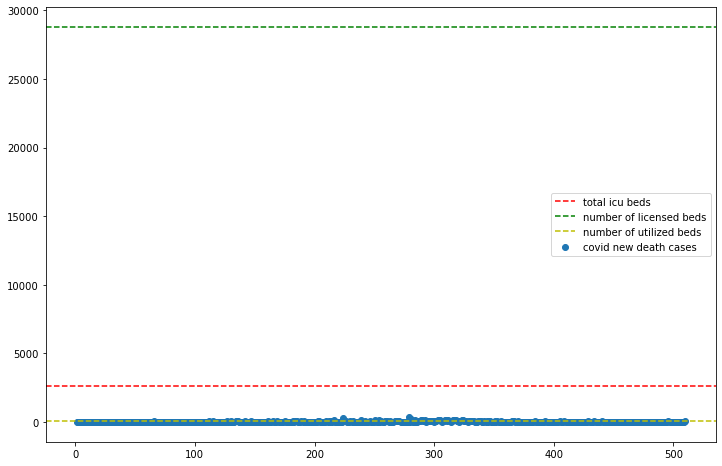

In [97]:
plt. figure(figsize=(12,8))
plt.scatter(nc_super_df_first_deathcase['num_of_days'],abs(nc_super_df_first_deathcase['new_death_cases']),label="covid new death cases")
plt.axhline(y=icu_beds, color='r', label="total icu beds",linestyle='--')
plt.axhline(y=total_beds, color='g', label = "number of licensed beds",linestyle='--')
plt.axhline(y=number_of_utilized_beds, color='y', label = "number of utilized beds",linestyle='--')
plt.title("Hospital beds analysis")
plt.xlabel("Number of days")
plt.ylabel("Number of cases")
plt.legend()
plt.show("png")

## Plot the graph with number of covid new cases
#### By looking at the plots of number of everyday cases and icu/beds available, we can see that icu beds just crosses in between the scatter plot. That doesn't mean there are no enough beds available. Not all the infected people will be hospitalized. That is why we should compare the death cases and available beds

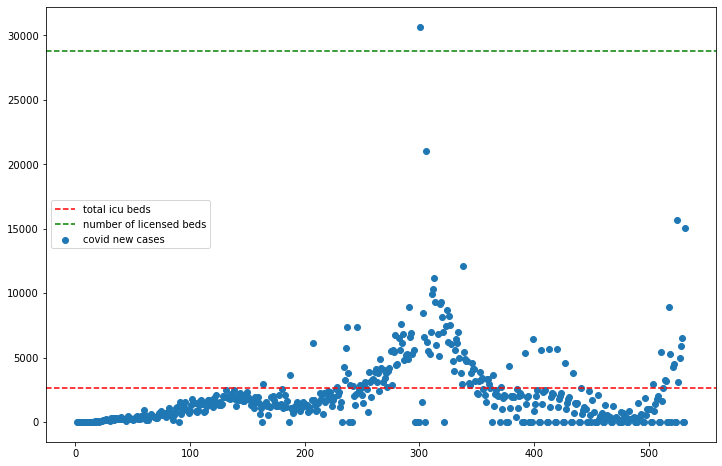

In [98]:
plt. figure(figsize=(12,8))
plt.scatter(nc_super_df_firstcase['num_of_days'],abs(nc_super_df_firstcase['new_cases']),label="covid new cases")
plt.axhline(y=icu_beds, color='r',label="total icu beds",linestyle='--')
plt.axhline(y=total_beds, color='g',label = "number of licensed beds",linestyle='--')
plt.title("Hospital beds analysis")
plt.xlabel("Number of days")
plt.ylabel("Number of cases")
plt.legend()
plt.show("png")

## Calculating California beds and cases to compare with North Carolina

In [99]:
hosp_bead_ca = hospital_bed_data[hospital_bed_data['HQ_STATE']=='LA']
icu_beds_ca = hosp_bead_ca['NUM_ICU_BEDS'].sum()
total_beds_ca = hosp_bead_ca['NUM_LICENSED_BEDS'].sum()
number_of_utilized_beds_ca = (hosp_bead_ca['NUM_LICENSED_BEDS'].mean())*(hosp_bead_ca['BED_UTILIZATION'].mean())
hosp_bead_ca

,X,Y,OBJECTID,HOSPITAL_NAME,HOSPITAL_TYPE,HQ_ADDRESS,HQ_ADDRESS1,HQ_CITY,HQ_STATE,HQ_ZIP_CODE,...,CNTY_FIPS,FIPS,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
2050,-90.700216,30.046704,6051,Beacon Behavioral Hospital - Lutcher,Psychiatric Hospital,2471 Louisiana Ave,0,Lutcher,LA,70071.0,...,93.0,22093,19,19,0,0,0,0.854650,0,0.0
2051,-91.144901,30.449648,6052,Seaside Health System - Baton Rouge,Psychiatric Hospital,4363 Convention St,0,Baton Rouge,LA,70806.0,...,33.0,22033,64,64,0,0,0,0.834247,0,0.0
2052,-90.771233,29.664913,6053,Compass Behavioral Center of Houma,Psychiatric Hospital,4701 W Park Ave,0,Houma,LA,70364.0,...,109.0,22109,20,20,0,0,0,0.805191,0,0.0
2107,-90.124600,29.925700,6108,Child and Adolescent Behavioral Health Center,Childrens Hospital,1040 Calhoun St,0,New Orleans,LA,70118.0,...,71.0,22071,0,0,72,72,0,0.000000,0,0.0
2117,-91.076554,30.425441,6118,Apollo Behavioral Health Hospital,Psychiatric Hospital,9938 Airline Hwy,0,Baton Rouge,LA,70816.0,...,33.0,22033,18,18,0,0,0,0.827245,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6326,-93.286614,32.617701,1709,Minden Medical Center,Short Term Acute Care Hospital,1 Medical Plaza Pl,0,Minden,LA,71055.0,...,119.0,22119,161,125,10,10,2,0.228934,36,4.0
6327,-93.443890,33.010286,1710,Springhill Medical Center,Short Term Acute Care Hospital,2001 Doctors Dr,0,Springhill,LA,71075.0,...,119.0,22119,58,46,6,6,0,0.151042,12,2.0
6328,-91.382047,32.868356,1711,West Carroll Memorial Hospital,Short Term Acute Care Hospital,706 Ross St,0,Oak Grove,LA,71263.0,...,123.0,22123,30,30,5,5,0,0.549406,0,0.0
6329,-91.366706,30.783719,1712,West Feliciana Parish Hospital,Critical Access Hospital,5266 Commerce St,0,Saint Francisville,LA,70775.0,...,125.0,22125,25,25,4,4,0,0.070027,0,2.0


In [100]:
covid_data_df_ca = covid_data_df[covid_data_df['State']=='CA']
covid_data_death_df_ca = death_df[death_df['State']=='CA']

In [101]:
covid_data_df_ca_idx = covid_data_df_ca.set_index(['countyFIPS','County Name','State','StateFIPS'])
covid_data_df_ca_idx_diff = covid_data_df_ca_idx.diff(axis=1)
covid_data_df_ca_idx_diff = covid_data_df_ca_idx_diff.drop(columns=['2020-01-22'])
covid_data_df_ca_idx_diff = covid_data_df_ca_idx_diff.reset_index()
covid_data_melt_ca = covid_data_df_ca_idx_diff.melt(id_vars=['County Name','countyFIPS','State','StateFIPS'],var_name="Date", value_name="new_cases")
covid_data_melt_ca = covid_data_melt_ca.rename(columns={"County Name":"CountyName"})
covid_data_melt_ca

,CountyName,countyFIPS,State,StateFIPS,Date,new_cases
0,Alameda County,6001,CA,6,2020-01-23,0.0
1,Alpine County,6003,CA,6,2020-01-23,0.0
2,Amador County,6005,CA,6,2020-01-23,0.0
3,Butte County,6007,CA,6,2020-01-23,0.0
4,Calaveras County,6009,CA,6,2020-01-23,0.0
...,...,...,...,...,...,...
33171,Tulare County,6107,CA,6,2021-08-16,414.0
33172,Tuolumne County,6109,CA,6,2021-08-16,89.0
33173,Ventura County,6111,CA,6,2021-08-16,691.0
33174,Yolo County,6113,CA,6,2021-08-16,187.0


In [102]:
covid_data_df_death_ca_idx = covid_data_death_df_ca.set_index(['countyFIPS','County Name','State','StateFIPS'])
covid_data_death_df_ca_idx_diff = covid_data_df_death_ca_idx.diff(axis=1)
covid_data_death_df_ca_idx_diff = covid_data_death_df_ca_idx_diff.drop(columns=['2020-01-22'])
covid_data_death_df_ca_idx_diff = covid_data_death_df_ca_idx_diff.reset_index()
covid_data_death_melt_ca = covid_data_death_df_ca_idx_diff.melt(id_vars=['County Name','countyFIPS','State','StateFIPS'],var_name="Date", value_name="new_death_cases")
covid_data_death_melt_ca = covid_data_death_melt_ca.rename(columns={"County Name":"CountyName"})
covid_data_death_melt_ca

,CountyName,countyFIPS,State,StateFIPS,Date,new_death_cases
0,Alameda County,6001,CA,6,2020-01-23,0.0
1,Alpine County,6003,CA,6,2020-01-23,0.0
2,Amador County,6005,CA,6,2020-01-23,0.0
3,Butte County,6007,CA,6,2020-01-23,0.0
4,Calaveras County,6009,CA,6,2020-01-23,0.0
...,...,...,...,...,...,...
33171,Tulare County,6107,CA,6,2021-08-16,0.0
33172,Tuolumne County,6109,CA,6,2021-08-16,0.0
33173,Ventura County,6111,CA,6,2021-08-16,0.0
33174,Yolo County,6113,CA,6,2021-08-16,1.0


In [103]:
new_cases_summed_bydate_ca = covid_data_melt_ca.groupby(['Date'])['new_cases'].sum().reset_index()
death_cases_summed_bydate_ca = covid_data_death_melt_ca.groupby(['Date'])['new_death_cases'].sum().reset_index()
ca_super_df = pd.merge(new_cases_summed_bydate_ca,death_cases_summed_bydate_ca)

In [104]:
new_case_firstday_ca = ca_super_df['new_cases'].astype(int).tolist()
new_death_case_firstday_ca = ca_super_df['new_death_cases'].astype(int).tolist()

In [105]:
newcase_ca = next((i for i, j in enumerate(new_case_firstday) if j >0 ), None)
ca_super_df_firstcase = nc_super_df.loc[newcase_ca:,['Date','new_cases']]
# Add a new column num_of_days in an order of index, but starting from 1 to assign x-value i.e 
# number of days from the first day of infection
mylistca = []
for i in range(1,(len(ca_super_df_firstcase)+1)):
    mylistca.append(i)
ca_super_df_firstcase['num_of_days'] = mylistca
ca_super_df_firstcase.head()

,Date,new_cases,num_of_days
40,2020-03-03,1.0,1
41,2020-03-04,0.0,2
42,2020-03-05,0.0,3
43,2020-03-06,1.0,4
44,2020-03-07,0.0,5


In [106]:
new_death_case_ca = next((i for i, j in enumerate(new_death_case_firstday_ca) if j >0 ), None)
ca_super_df_first_deathcase = ca_super_df.loc[new_death_case_ca:,['Date','new_death_cases']]

In [107]:
mylist2ca = []
for i in range(1,(len(ca_super_df_first_deathcase)+1)):
    mylist2ca.append(i)
ca_super_df_first_deathcase['num_of_days'] = mylist2ca
ca_super_df_first_deathcase.head()

,Date,new_death_cases,num_of_days
14,2020-02-06,1.0,1
15,2020-02-07,0.0,2
16,2020-02-08,0.0,3
17,2020-02-09,0.0,4
18,2020-02-10,0.0,5


In [108]:
nc_super_df.to_csv('../../../../data/stage_3/ca_super_data.csv',index=False)
#load_nc = pd.read_csv('../../../../data/stage_3/nc_super_data.csv')

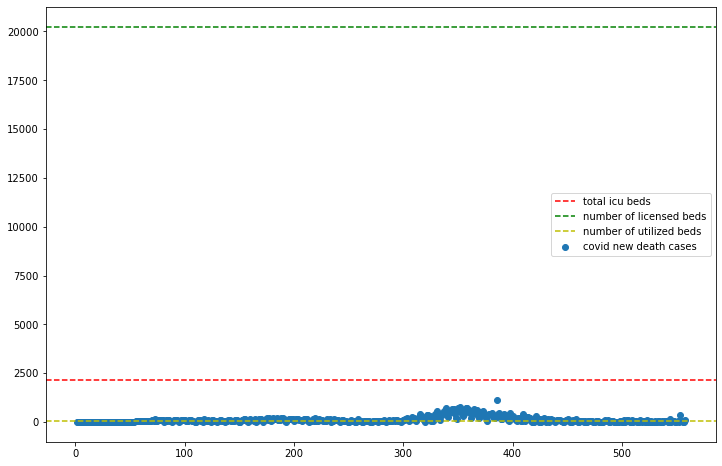

In [109]:
plt. figure(figsize=(12,8))
plt.scatter(ca_super_df_first_deathcase['num_of_days'],abs(ca_super_df_first_deathcase['new_death_cases']),label="covid new death cases")
plt.axhline(y=icu_beds_ca, color='r',label="total icu beds",linestyle='--')
plt.axhline(y=total_beds_ca, color='g',label = "number of licensed beds",linestyle='--')
plt.axhline(y=number_of_utilized_beds_ca, color='y', label = "number of utilized beds",linestyle='--')
plt.title("Hospital beds analysis")
plt.xlabel("Number of days")
plt.ylabel("Number of cases")
plt.legend()
plt.show("png")

## Hypothesis Testing
#### Are the number of cases affect the number of beds in NC state?
####  Null Hypothesis -  There is no change in the number of cases wrt number of beds availability
#### Alternate hypothesis - The number of beds are impacted by the number of cases in NC

In [110]:
total_nc_icu_beds = hospital_bed.groupby(['COUNTY_NAME'])['NUM_ICU_BEDS'].sum().reset_index()
total_nc_cases = hosp_covid_merge.groupby(['COUNTY_NAME'])['new_cases'].sum().reset_index()
total_nc_death_cases = hosp_covid_merge.groupby(['COUNTY_NAME'])['new_death_cases'].sum().reset_index()
licensed_beds = hospital_bed.groupby(['COUNTY_NAME'])['NUM_LICENSED_BEDS'].sum().reset_index()
total_nc_cases_merged = pd.merge(total_nc_icu_beds,total_nc_cases)
total_nc_cases_merged = pd.merge(total_nc_cases_merged,total_nc_death_cases)
total_nc_cases_merged = pd.merge(total_nc_cases_merged,licensed_beds)
total_nc_cases_merged

,COUNTY_NAME,NUM_ICU_BEDS,new_cases,new_death_cases,NUM_LICENSED_BEDS
0,Alamance,20,20380.0,289.0,238
1,Alleghany,4,1143.0,5.0,41
2,Anson,3,2847.0,57.0,15
3,Ashe,4,2456.0,45.0,76
4,Avery,4,2238.0,21.0,50
...,...,...,...,...,...
75,Washington,4,1197.0,32.0,49
76,Watauga,10,5240.0,33.0,117
77,Wayne,16,24982.0,494.0,569
78,Wilkes,8,7813.0,119.0,130


## Hypothesis Testing
#### Hypothesis -1 - Is there a relation between number of beds and number of new cases in NC?
#### Null Hypothesis - Number of new cases and numer of ICU beds are same
#### Alternate Hypothesis - There is a difference in number of new cases and numer of ICU beds

In [111]:
stats.ttest_ind(a= total_nc_cases_merged['new_cases'],
                b= total_nc_cases_merged['NUM_ICU_BEDS'],
                equal_var=False)

Ttest_indResult(statistic=2.5313129671561287, pvalue=0.013348508538039651)

#### From the above results, p-value is lesser than 0.05. Hence we can reject the null hypothesis. There is a difference between the number of cases and number of icu beds

## Hypothesis 2 -  Are number of death cases connected to number of icu beds?
#### Null hypothesis - There is no change in the vlaues of number of death cases and number of icu beds
#### Alternate hypothesis - There is a change in the vlaues of number of death cases and number of icu beds

In [112]:
stats.ttest_ind(a= total_nc_cases_merged['new_death_cases'],
                b= total_nc_cases_merged['NUM_ICU_BEDS'],
                equal_var=False)

Ttest_indResult(statistic=2.953561111601688, pvalue=0.004134132793445403)

#### From the above results, p-value is lesser than 0.05. Hence we can reject the null hypothesis. There is a difference between the number of cases and number of icu beds

## Hypothesis Testing from Stage 2 
#### Does the total population of Male affect the number of covid cases?
#### Null Hypothesis:- There is no change in the covid cases wrt total male population
#### Alternative Hypothesis:- There is a change in the covid cases wrt total male population

In [113]:
## Loading the acs census and demographic dataset
enrichment_acs = pd.read_csv('../../../../data/stage_3/enrichment_demographic.csv')

In [114]:
enrichment_acs.head()

,countyFIPS,Estimate!!SEX AND AGE!!Total population,Margin of Error!!SEX AND AGE!!Total population,Percent!!SEX AND AGE!!Total population,Percent Margin of Error!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Male,Margin of Error!!SEX AND AGE!!Total population!!Male,Percent!!SEX AND AGE!!Total population!!Male,Percent Margin of Error!!SEX AND AGE!!Total population!!Male,Estimate!!SEX AND AGE!!Total population!!Female,...,"Margin of Error!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Female","Percent!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Female","Percent Margin of Error!!CITIZEN, VOTING AGE POPULATION!!Citizen, 18 and over population!!Female",County name,State_x,County Name,State_y,death_cases,newcases,population
0,1003.0,223234,*****,223234,(X),109192,1466,48.9,0.7,114042,...,1507,52.8,0.6,Calhoun County,Alabama,Baldwin County,AL,347.0,29234.0,223234
1,1015.0,113605,*****,113605,(X),54285,701,47.8,0.6,59320,...,739,53.2,0.4,Cullman County,Alabama,Calhoun County,AL,340.0,16340.0,113605
2,1043.0,83768,*****,83768,(X),40579,905,48.4,1.1,43189,...,683,52.0,0.6,DeKalb County,Alabama,Cullman County,AL,212.0,11279.0,83768
3,1049.0,71513,*****,71513,(X),35688,884,49.9,1.2,35825,...,808,50.7,1.4,Elmore County,Alabama,DeKalb County,AL,197.0,10074.0,71513
4,1051.0,81209,*****,81209,(X),40060,882,49.3,1.1,41149,...,418,52.5,0.6,Etowah County,Alabama,Elmore County,AL,226.0,11711.0,81209


In [115]:
enrichment_acs_nc = enrichment_acs[enrichment_acs['State_y']=='NC']

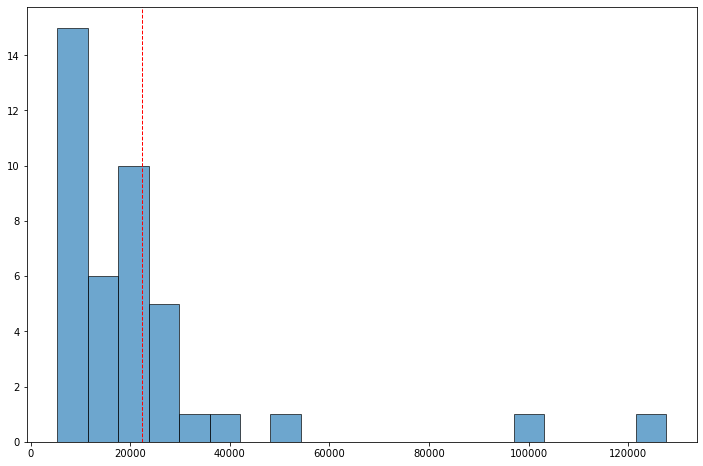

In [116]:
plt.figure(figsize=(12,8))
plt.hist(enrichment_acs_nc['newcases'], bins=20, edgecolor='k', alpha=0.65)
plt.axvline(enrichment_acs_nc['newcases'].mean(), color='r', linestyle='dashed', linewidth=1)

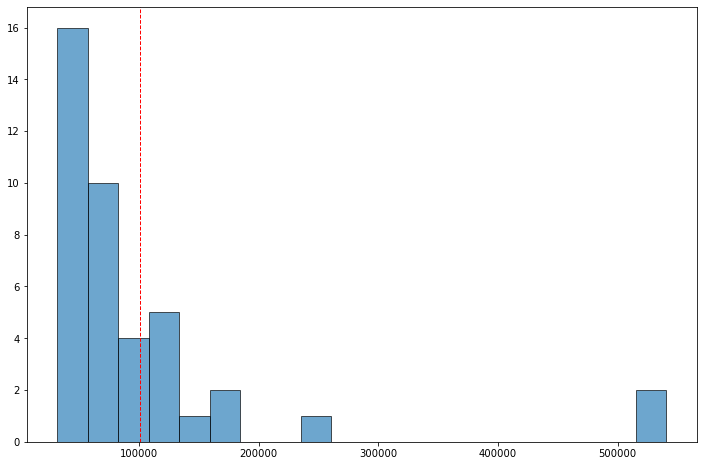

In [117]:
plt.figure(figsize=(12,8))
plt.hist(enrichment_acs_nc['Estimate!!SEX AND AGE!!Total population!!Male'], bins=20, edgecolor='k', alpha=0.65)
plt.axvline(enrichment_acs_nc['Estimate!!SEX AND AGE!!Total population!!Male'].mean(), color='r', linestyle='dashed', linewidth=1)

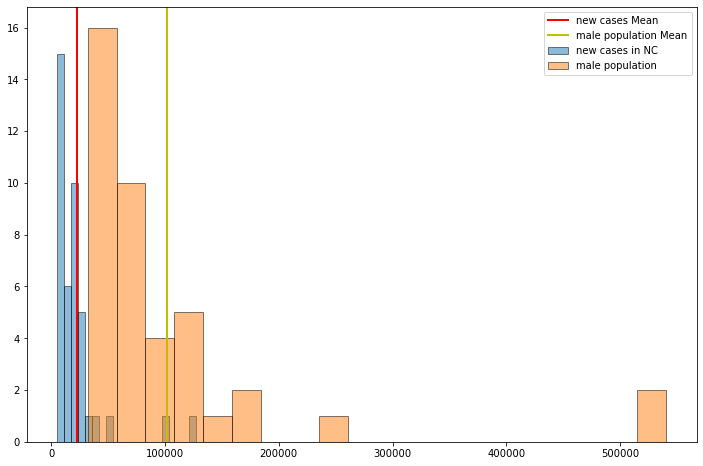

In [118]:
plt.figure(figsize=(12,8))

plt.hist(enrichment_acs_nc['newcases'], bins=20, edgecolor='k', alpha=0.5, label='new cases in NC')
plt.hist(enrichment_acs_nc['Estimate!!SEX AND AGE!!Total population!!Male'], bins=20, edgecolor='k', alpha=0.5, label='male population')
plt.axvline(enrichment_acs_nc['newcases'].mean(), color='r', linewidth=2, label='new cases Mean') 
plt.axvline(enrichment_acs_nc['Estimate!!SEX AND AGE!!Total population!!Male'].mean(), color='y',  linewidth=2, label='male population Mean') 
plt.legend(loc='upper right')
plt.show()

In [119]:
stats.ttest_ind(a= enrichment_acs_nc['newcases'],
                b= enrichment_acs_nc['Estimate!!SEX AND AGE!!Total population!!Male'],
                )

Ttest_indResult(statistic=-4.4935698486755955, pvalue=2.334331118524854e-05)

In [120]:
Greater =  0.0000023/2 < 0.1 and -4.49 > 0
Less = 0.0000023/2 < 0.1 and -4.49 < 0
print('Less',Less)
print('Greater',Greater)
print('Hence the value resides in the lower end of distribution')

Less True
Greater False
Hence the value resides in the lower end of distribution


#### The pvalue is resulted as 0.00023. If we are using 95% confidence intervals, our null hypothesis can be rejected. Meaning, the male population impact the total number of covid cases . since the p-value is less than the corresponding significance level of 5%, we can reject the null hypothesis

## Hypothesis Testing - Are the newcases and age group people between 45 to 54 years remains same?
#### Null Hypothesis - There is no difference between number of newcases and total population between ages of 45 to 54 years
#### Alternate Hypothesis - There is a change between number of newcases and total population between ages of 45 to 54 years

In [121]:
stats.ttest_ind(a= enrichment_acs_nc['newcases'],
                b= enrichment_acs_nc['Estimate!!SEX AND AGE!!Total population!!45 to 54 years'],
                )

Ttest_indResult(statistic=-0.8303467768980478, pvalue=0.40881390381911487)

In [122]:
Greater =  0.408/2 < 0.3 and -0.830 > 0
Less = 0.408/2 < 0.3 and -0.830 < 0
print('Less',Less)
print('Greater',Greater)
print('Hence the value resides in the lower end of distribution')

Less True
Greater False
Hence the value resides in the lower end of distribution


#### The p-value is 0.408. With the confidence interval being 95%, the p-value is 40.8% which is way more than 5% threshold. Hence we fail to reject the null hypothesis. These results tell us that people over 45 years are more prone to get infected. Also, there is a 40% chance we'd see sample data this far apart if the two groups tested are actually identical.